In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn.impute import SimpleImputer
import copy
import warnings

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

In [2]:
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
labevents = pd.read_csv('LABEVENTS.csv')
prescriptions = pd.read_csv('PRESCRIPTIONS.csv', low_memory=False)
labitems = pd.read_csv('D_LABITEMS.csv')
# microbiologyevents = pd.read_csv('MICROBIOLOGYEVENTS.csv')
# chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)

In [3]:
admissions = pd.merge(patients, admissions, on='SUBJECT_ID')

In [4]:
patients = admissions[['SUBJECT_ID', 'HADM_ID', 'GENDER', 'DOB', 'DOD_HOSP', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS']].copy()

In [5]:
patients = patients[patients['DIAGNOSIS']=='PNEUMONIA']

In [6]:
patients['ADMITTIME'] = pd.to_datetime(patients['ADMITTIME'], format='%Y-%m-%d %H:%M:%S').dt.date
patients['DISCHTIME'] = pd.to_datetime(patients['DISCHTIME'], format='%Y-%m-%d %H:%M:%S').dt.date

In [7]:
patients['STAYDAYS'] = (patients['DISCHTIME']-patients['ADMITTIME']).dt.days
patients = patients[patients['STAYDAYS']<30]

In [8]:
patients.DOD_HOSP = pd.to_datetime(patients.DOD_HOSP, format='%Y-%m-%d %H:%M:%S').dt.date
len(patients[patients.DOD_HOSP.isna()]), len(patients[~patients.DOD_HOSP.isna()])

(841, 661)

In [9]:
patients = patients.drop(index=patients[~patients.DOD_HOSP.isna()&(patients.DISCHTIME!=patients.DOD_HOSP)].index)

In [10]:
len(patients[patients.DOD_HOSP.isna()]), len(patients[~patients.DOD_HOSP.isna()])

(841, 256)

In [11]:
patients.loc[patients.DOD_HOSP.isna(), 'DEAD'] = 0
patients.loc[~patients.DOD_HOSP.isna(), 'DEAD'] = 1
patients['DEAD'] = patients['DEAD'].astype('int')

# Prescriptions

In [12]:
df = patients[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'STAYDAYS']].copy()

In [13]:
prescriptions = prescriptions[['SUBJECT_ID', 'HADM_ID', 'STARTDATE', 'ENDDATE', 'DRUG_TYPE', 'DRUG', 'DOSE_VAL_RX', 'DOSE_UNIT_RX', 'ROUTE']]

In [14]:
prescriptions = pd.merge(df, prescriptions[prescriptions.HADM_ID.isin(df.HADM_ID)], on=['SUBJECT_ID', 'HADM_ID'], how='left')
prescriptions['STARTDATE'] = pd.to_datetime(prescriptions['STARTDATE'], format='%Y-%m-%d %H:%M:%S').dt.date
prescriptions['ENDDATE'] = pd.to_datetime(prescriptions['ENDDATE'], format='%Y-%m-%d %H:%M:%S').dt.date

In [15]:
prescriptions.loc[prescriptions['STARTDATE'] < prescriptions['ADMITTIME'], 'STARTDATE'] = prescriptions.loc[prescriptions['STARTDATE'] < prescriptions['ADMITTIME'], 'ADMITTIME']
prescriptions.loc[prescriptions['DISCHTIME'] < prescriptions['ENDDATE'], 'ENDDATE'] = prescriptions.loc[prescriptions['DISCHTIME'] < prescriptions['ENDDATE'], 'DISCHTIME']

In [16]:
prescriptions = prescriptions[((prescriptions['ADMITTIME'] <= prescriptions['STARTDATE'])&(prescriptions['STARTDATE'] <= prescriptions['DISCHTIME']))
                                 |((prescriptions['ADMITTIME'] <= prescriptions['ENDDATE'])&(prescriptions['ENDDATE'] <= prescriptions['DISCHTIME']))]
prescriptions['days'] = (prescriptions['ENDDATE'] - prescriptions['STARTDATE']).dt.days +1
prescriptions = prescriptions.drop(index=prescriptions[prescriptions['days']<1].index)

In [17]:
prescriptions = prescriptions[~prescriptions['DOSE_VAL_RX'].isna()]

In [18]:
prescriptions.loc[prescriptions['DOSE_VAL_RX'].str.contains('-'), 'DOSE_VAL_RX'] =\
                        (prescriptions.loc[prescriptions['DOSE_VAL_RX'].str.contains('-'), 'DOSE_VAL_RX'].str.split('-').str[0].astype('float')
                            +prescriptions.loc[prescriptions['DOSE_VAL_RX'].str.contains('-'), 'DOSE_VAL_RX'].str.split('-').str[1].astype('float'))/2

In [19]:
prescriptions.insert(2, 'EVENTDATE', None)
prescriptions.reset_index(drop=True, inplace=True)

In [20]:
prescriptions.loc[prescriptions.days==1, 'EVENTDATE'] = prescriptions.loc[prescriptions.days==1, 'STARTDATE']

In [21]:
temp_list = []
for i in prescriptions[prescriptions.days>1].index:
    STARTDATE = prescriptions.loc[i, 'STARTDATE']
    ENDDATE = prescriptions.loc[i, 'ENDDATE']
    days = prescriptions.loc[i, 'days']
    temp = pd.concat([prescriptions.loc[[i], :]]*int(days))
    temp['EVENTDATE'] = pd.date_range(start = STARTDATE, end = ENDDATE).tolist()
    temp['EVENTDATE'] = temp['EVENTDATE'].dt.date
    temp_list.append(temp)
    # print(pd.date_range(start = STARTDATE, end = ENDDATE).tolist())
prescriptions = pd.concat(temp_list+[prescriptions[prescriptions.days==1]], ignore_index=True)

In [22]:
# temp = prescriptions['DOSE_VAL_RX'].str.extract('([^0-9.]+)')
# temp[~temp[0].isna()]

In [23]:
prescriptions['DOSE_VAL_RX'] = prescriptions['DOSE_VAL_RX'].str.replace(',', '').str.replace('[ ]+', '', regex=True).str.replace('%', '').str.replace('regular', '').replace({'0.63/3':'0.63'}).astype('float')

In [24]:
prescriptions.DRUG = prescriptions.DRUG.str.replace('[0-9.]+[%]+', '', regex=True).str.replace('[(].*[)]', '', regex=True).str.strip().str.upper()

In [25]:
prescriptions = prescriptions[prescriptions.DRUG.isin(prescriptions.DRUG.value_counts()[:50].index)]
prescriptions.DOSE_UNIT_RX = prescriptions.DOSE_UNIT_RX.replace('gm', 'g')
prescriptions.loc[(prescriptions.DOSE_UNIT_RX=='g'), 'DOSE_VAL_RX'] = prescriptions.loc[(prescriptions.DOSE_UNIT_RX=='g'), 'DOSE_VAL_RX']*1000
prescriptions.loc[(prescriptions.DOSE_UNIT_RX=='g'), 'DOSE_UNIT_RX'] = 'mg'
prescriptions['DOSE_UNIT_RX'] = prescriptions['DOSE_UNIT_RX'].str.lower()

In [26]:
pd.pivot_table(prescriptions, index=['HADM_ID', 'EVENTDATE'], columns=['DRUG', 'DOSE_UNIT_RX'], values='DOSE_VAL_RX', aggfunc="sum")

DRUG               ACETAMINOPHEN ALBUTEROL  NEB SOLN ALBUTEROL INHALER  \
DOSE_UNIT_RX                  mg                 neb              puff   
HADM_ID EVENTDATE                                                        
100016  2188-05-24           NaN                 NaN               0.0   
        2188-05-25           NaN                 NaN               0.0   
        2188-05-26           NaN                 NaN               0.0   
        2188-05-27           NaN                 NaN               0.0   
        2188-05-28           NaN                 NaN               0.0   
...                          ...                 ...               ...   
199999  2136-04-06           0.0                 1.0               NaN   
        2136-04-07           0.0                 1.0               NaN   
        2136-04-08           0.0                 1.0               NaN   
        2136-04-09           0.0                 1.0               NaN   
        2136-04-10           0.0                 1.0               NaN   

DRUG               ASPIRIN AZITHROMYCIN BAG       BISACODYL CALCIUM GLUCONATE  \
DOSE_UNIT_RX            mg           mg bag    ml        mg                mg   
HADM_ID EVENTDATE                                                               
100016  2188-05-24     NaN          NaN NaN   NaN      20.0               NaN   
        2188-05-25     NaN          NaN NaN   NaN      20.0               NaN   
        2188-05-26     NaN          NaN NaN   NaN      20.0               NaN   
        2188-05-27     NaN          NaN NaN  50.0      20.0               NaN   
        2188-05-28     NaN          NaN NaN  50.0      20.0               NaN   
...                    ...          ...  ..   ...       ...               ...   
199999  2136-04-06    81.0        500.0 NaN   NaN       NaN               NaN   
        2136-04-07    81.0        500.0 NaN  50.0       NaN               NaN   
        2136-04-08    81.0        500.0 NaN  50.0       NaN               NaN   
        2136-04-09    81.0        500.0 NaN   NaN       NaN               NaN   
        2136-04-10    81.0          NaN NaN   NaN       NaN               NaN   

DRUG               CEFEPIME CEFTRIAXONE CHLORHEXIDINE GLUCONATE  ORAL RINSE  \
DOSE_UNIT_RX             mg          mg                                  ml   
HADM_ID EVENTDATE                                                             
100016  2188-05-24   2000.0         NaN                                30.0   
        2188-05-25   4000.0         NaN                                15.0   
        2188-05-26   2000.0         NaN                                15.0   
        2188-05-27   2000.0         NaN                                15.0   
        2188-05-28   4000.0         NaN                                30.0   
...                     ...         ...                                 ...   
199999  2136-04-06      NaN      1000.0                                 NaN   
        2136-04-07      NaN         NaN                                 NaN   
        2136-04-08      NaN         NaN                                 NaN   
        2136-04-09      NaN         NaN                                 NaN   
        2136-04-10      NaN         NaN                                 NaN   

DRUG               D5W DEXTROSE             DILTIAZEM DOCUSATE SODIUM  \
DOSE_UNIT_RX        ml       mg      ml syr        mg              mg   
HADM_ID EVENTDATE                                                       
100016  2188-05-24 NaN      NaN   150.0 NaN       NaN           100.0   
        2188-05-25 NaN      NaN   150.0 NaN       NaN           100.0   
        2188-05-26 NaN      NaN  1150.0 NaN       NaN           100.0   
        2188-05-27 NaN      NaN  1150.0 NaN       NaN           100.0   
        2188-05-28 NaN      NaN   150.0 NaN       NaN           100.0   
...                 ..      ...     ...  ..       ...             ...   
199999  2136-04-06 NaN      NaN   400.0 NaN       NaN           

In [47]:
prescriptions[(prescriptions.DRUG=='CEFEPIME')&(prescriptions.DOSE_UNIT_RX=='mg')]

,SUBJECT_ID,HADM_ID,EVENTDATE,ADMITTIME,DISCHTIME,STAYDAYS,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DOSE_VAL_RX,DOSE_UNIT_RX,ROUTE,days
2556,346,195392,2149-11-30,2149-11-29,2149-12-05,6,2149-11-30,2149-12-03,MAIN,CEFEPIME,2000.0,mg,IV,4.0
2557,346,195392,2149-12-01,2149-11-29,2149-12-05,6,2149-11-30,2149-12-03,MAIN,CEFEPIME,2000.0,mg,IV,4.0
2558,346,195392,2149-12-02,2149-11-29,2149-12-05,6,2149-11-30,2149-12-03,MAIN,CEFEPIME,2000.0,mg,IV,4.0
2559,346,195392,2149-12-03,2149-11-29,2149-12-05,6,2149-11-30,2149-12-03,MAIN,CEFEPIME,2000.0,mg,IV,4.0
5313,2090,146557,2137-12-03,2137-12-03,2137-12-14,11,2137-12-03,2137-12-04,MAIN,CEFEPIME,2000.0,mg,IV,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290608,75983,126484,2134-02-12,2134-02-11,2134-02-17,6,2134-02-12,2134-02-12,MAIN,CEFEPIME,2000.0,mg,IV,1.0
290815,78705,151651,2183-12-25,2183-12-24,2184-01-02,9,2183-12-25,2183-12-25,MAIN,CEFEPIME,2000.0,mg,IV,1.0
290902,79055,141509,2164-10-08,2164-09-27,2164-10-12,15,2164-10-08,2164-10-08,MAIN,CEFEPIME,2000.0,mg,IV,1.0
290986,70226,114222,2181-09-21,2181-09-20,2181-10-02,12,2181-09-21,2181-09-21,MAIN,CEFEPIME,2000.0,mg,IV,1.0


In [36]:
pd.pivot_table(prescriptions, index=['HADM_ID', 'STARTDATE', 'ENDDATE'], columns='DRUG', values=['DOSE_VAL_RX'])

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,STAYDAYS,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DOSE_VAL_RX,DOSE_UNIT_RX,ROUTE
0,705,113494,2156-08-23,2156-08-26,3,2156-08-25,2156-08-26,MAIN,Morphine Sulfate,3.0,mg,IV
1,705,113494,2156-08-23,2156-08-26,3,2156-08-26,2156-08-26,MAIN,Morphine Sulfate,100,mg,IV DRIP
2,705,113494,2156-08-23,2156-08-26,3,2156-08-26,2156-08-26,BASE,D5W,100,ml,IV DRIP
3,705,113494,2156-08-23,2156-08-26,3,2156-08-26,2156-08-26,MAIN,Albuterol,1.5,PUFF,IH
4,705,113494,2156-08-23,2156-08-26,3,2156-08-26,2156-08-27,MAIN,Morphine Sulfate,10,mg,IV DRIP
...,...,...,...,...,...,...,...,...,...,...,...,...
82077,43959,135209,2110-07-03,2110-07-06,3,2110-07-03,2110-07-04,BASE,Iso-Osmotic Dextrose,200,mL,IV
82078,43959,135209,2110-07-03,2110-07-06,3,2110-07-03,2110-07-04,BASE,Dextrose 5%,150,mL,IV
82079,43959,135209,2110-07-03,2110-07-06,3,2110-07-03,2110-07-06,MAIN,Pneumococcal Vac Polyvalent,0.5,mL,IM
82080,43959,135209,2110-07-03,2110-07-06,3,2110-07-03,2110-07-06,MAIN,OxycoDONE-Acetaminophen Elixir,5,mL,PO/NG


# Lab

In [12]:
lab = pd.merge(labevents[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM', 'VALUEUOM']], labitems[['ITEMID', 'LABEL', 'FLUID']], on='ITEMID', how='left')

In [13]:
lab['FLUID'] = lab['FLUID'].str.replace('[Bb][Ll][Oo]{2}[Dd]', 'Blood', regex=True)

In [14]:
def find_same_name(df):
    df['new_name'] = df['LABEL'].str.lower().str.replace('[ ]+', '', regex=True)
    temp = dict(zip(lab['LABEL'], lab['new_name']))
    dup = [x for i, x in enumerate(list(temp.values())) if x in list(temp.values())[:i]]

    temp = {new:list(df.loc[df.new_name==new, 'LABEL'].unique()) for new in dup}
    for k in temp.keys():
        df.loc[df['new_name']==k, 'LABEL'] = temp[k][0]
        
    return df.drop(columns='new_name')

In [15]:
lab = find_same_name(lab)
lab = lab[~lab.VALUENUM.isna()]
lab['CHARTTIME'] = pd.to_datetime(lab['CHARTTIME'], format='%Y-%m-%d %H:%M:%S').dt.date

In [16]:
lab['LABEL'] = lab['LABEL']+'_'+lab['FLUID']
lab = lab[lab.LABEL.isin(lab['LABEL'].value_counts()[:50].index)]

In [17]:
lab = pd.pivot_table(lab, columns='LABEL', index=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'], values='VALUENUM', aggfunc='mean').reset_index()

In [18]:
df = patients[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'STAYDAYS']].copy()

In [19]:
lab = pd.merge(df, lab, on=['SUBJECT_ID', 'HADM_ID'], how='left')
lab = lab[(lab.CHARTTIME>=lab.ADMITTIME)&(lab.CHARTTIME<=lab.DISCHTIME)]

In [20]:
lab['DAY'] = (lab['CHARTTIME']-lab['ADMITTIME']).dt.days
lab = lab.reset_index(drop=True)

In [21]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean.fit(lab.iloc[:, 6:])
# lab.iloc[:, 6:] = imp_mean.transform(lab.iloc[:, 6:])

In [21]:
from sklearn.preprocessing import MinMaxScaler

# 편의를 위해 train test split 전에 normalization
sc = MinMaxScaler()

lab.iloc[:, 6:-1] = sc.fit_transform(lab.iloc[:, 6:-1])

In [22]:
lab.iloc[:, 6:] = lab.iloc[:, 6:].fillna(0)
lab = lab.sort_values(['SUBJECT_ID','HADM_ID'])

In [23]:
X = np.array([np.array([np.array(group.loc[group.DAY==d, lab.columns[6:-1]].values[0]) if d in group.DAY.values else np.array([0]*len(lab.columns[6:-1])) for d in range(30)]) for (s, h), group in lab.groupby(['SUBJECT_ID','HADM_ID'], sort=False)])

In [24]:
X.shape

(1091, 30, 50)

In [25]:
y = pd.merge(lab[['SUBJECT_ID','HADM_ID']], patients[['SUBJECT_ID', 'DEAD']], how='left').drop_duplicates()

In [26]:
y = np.array(y['DEAD'])

In [27]:
y.shape

(1091,)

In [28]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

In [29]:
X.shape

(872, 30, 50)

In [30]:
X_client1 = X[:100]
X_client2 = X[100:]
y_client1 = y[:100]
y_client2 = y[100:]

# X_test = X[-80:]
# y_test = y[-80:]

In [31]:
y.shape

(872,)

In [32]:
X_client1_t, X_client1_v, y_client1_t, y_client1_v = train_test_split(X_client1, y_client1, test_size=0.2, stratify=y_client1, random_state=321)
X_client2_t, X_client2_v, y_client2_t, y_client2_v = train_test_split(X_client2, y_client2, test_size=0.2, stratify=y_client2, random_state=321)

In [33]:
y_test.sum()

48

In [34]:
y_client1_t = y_client1_t.astype('float32')
y_client1_v = y_client1_v.astype('float32')
y_client2_t = y_client2_t.astype('float32')
y_client2_v = y_client2_v.astype('float32')
y_test = y_test.astype('float32')

In [35]:
import tensorflow as tf
from tqdm import tqdm

tf.random.set_seed(0)
np.random.seed(0)

2023-09-19 10:22:25.920968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-19 10:22:25.920989: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [47]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Bidirectional, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def build_model():
    input_layer = Input(shape=(30, 50))
    x = Bidirectional(LSTM(32))(input_layer)
    x = Dropout(0.1)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

def evaluate(model, X, y):
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob>0.5).astype(int)
    auroc = roc_auc_score(y, y_pred_prob)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    return {'sensitivity':[round(sens, 2)], 'specificity':[round(spec, 2)], 'ppv':[round(ppv, 2)], 'npv':[round(npv, 2)], 'AUROC':[round(auroc, 2)]}

In [37]:
model1 = build_model()

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
          batch_size=8, verbose=0, callbacks=[early_stop])

2023-09-19 10:22:26.876132: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-19 10:22:26.876153: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nccai-System-Product-Name): /proc/driver/nvidia/version does not exist
2023-09-19 10:22:26.876498: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
model2 = build_model()

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

model1.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
          batch_size=8, verbose=0, callbacks=[early_stop])

In [39]:
evaluate(model1, X_client1_v, y_client1_v)

{'sensitivity': [0.33],
 'specificity': [1.0],
 'ppv': [1.0],
 'npv': [0.78],
 'AUROC': [0.89]}

In [40]:
evaluate(model2, X_client2_v, y_client2_v)

{'sensitivity': [0.94],
 'specificity': [0.01],
 'ppv': [0.22],
 'npv': [0.33],
 'AUROC': [0.59]}

In [41]:
evaluate(model1, X_test, y_test)

{'sensitivity': [0.77],
 'specificity': [0.92],
 'ppv': [0.73],
 'npv': [0.93],
 'AUROC': [0.9]}

In [42]:
evaluate(model2, X_test, y_test)

{'sensitivity': [0.96],
 'specificity': [0.0],
 'ppv': [0.21],
 'npv': [0.0],
 'AUROC': [0.47]}

In [43]:
#FedAvg
client_size = []
client1_v_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])
client2_v_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])
test_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])

tf.random.set_seed(0)
np.random.seed(0)

num_round = 10

for n in tqdm(range(1, num_round+1)):
    weights_list = []
    if n == 1 :
        #client1
        model1 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client1_t))
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client2_t))
        weights_list.append(model2.get_weights())
        
        #client local model 각각에 대한 test set 성능 평균
        temp_df = pd.DataFrame(evaluate(model1, X_test, y_test))
        temp_df = pd.concat([temp_df, pd.DataFrame(evaluate(model2, X_test, y_test))], ignore_index=True)
        test_df = test_df.append(temp_df.mean().round(2), ignore_index=True)
        
    else :
        #client1
        model1 = build_model()
        model1.set_weights(new_weights)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_model()
        model2.set_weights(new_weights)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        weights_list.append(model2.get_weights())
    
    client1_v_df = pd.concat([client1_v_df, pd.DataFrame(evaluate(model1, X_client1_v, y_client1_v))], ignore_index=True)
    client2_v_df = pd.concat([client2_v_df, pd.DataFrame(evaluate(model2, X_client1_v, y_client1_v))], ignore_index=True)
    
    #Aggregation
    new_weights = []
    for i in range(len(weights_list[0])): #몇번째 weight
        temp = np.zeros_like(weights_list[0][i])
        for j in range(len(weights_list)): #몇번째 client
            temp += weights_list[j][i]
        temp = temp/len(weights_list)
        new_weights.append(temp)

    global_model = build_model()
    global_model.set_weights(new_weights)

    test_df = pd.concat([test_df, pd.DataFrame(evaluate(global_model, X_test, y_test))], ignore_index=True)

client1_v_df.index = list(range(1, num_round+1))
client2_v_df.index = list(range(1, num_round+1))
test_df.index = ['local model 평균']+list(range(1, num_round+1))

 10%|████▍                                       | 1/10 [00:46<07:02, 46.93s/it]

 20%|████████▊                                   | 2/10 [01:40<06:48, 51.10s/it]

100%|███████████████████████████████████████████| 10/10 [07:48<00:00, 46.87s/it]


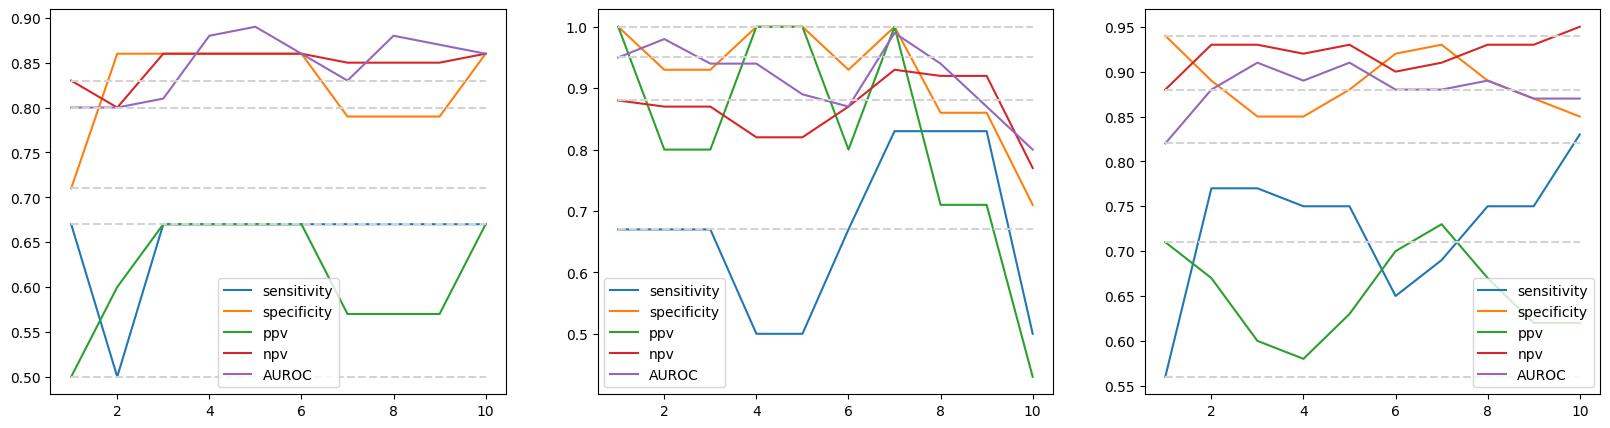

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
client1_v_df.plot(ax=axes[0])
axes[0].hlines(client1_v_df.iloc[:1, :], 1, 10, colors='lightgray', linestyle='--')
client2_v_df.plot(ax=axes[1])
axes[1].hlines(client2_v_df.iloc[:1, :], 1, 10, colors='lightgray', linestyle='--')
test_df.iloc[1:, :].plot(ax=axes[2])
axes[2].hlines(test_df.iloc[1:2, :], 1, 10, colors='lightgray', linestyle='--')
plt.show()

In [74]:
#weighted FedAvg
client_size = []
client1_v_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])
client2_v_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])
test_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])

tf.random.set_seed(0)
np.random.seed(0)

num_round = 10

for n in tqdm(range(1, num_round+1)):
    weights_list = []
    if n == 1 :
        #client1
        model1 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client1_t))
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client2_t))
        weights_list.append(model2.get_weights())
        
        #client local model 각각에 대한 test set 성능 평균
        temp_df = pd.DataFrame(evaluate(model1, X_test, y_test))
        temp_df = pd.concat([temp_df, pd.DataFrame(evaluate(model2, X_test, y_test))], ignore_index=True)
        test_df = test_df.append(temp_df.mean().round(2), ignore_index=True)
        
    else :
        #client1
        model1 = build_model()
        model1.set_weights(new_weights)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_model()
        model2.set_weights(new_weights)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        weights_list.append(model2.get_weights())
    
    client1_v_df = pd.concat([client1_v_df, pd.DataFrame(evaluate(model1, X_client1_v, y_client1_v))], ignore_index=True)
    client2_v_df = pd.concat([client2_v_df, pd.DataFrame(evaluate(model2, X_client1_v, y_client1_v))], ignore_index=True)
    
    #Aggregation
    new_weights = []
    for i in range(len(weights_list[0])): #몇번째 weight
        temp = np.zeros_like(weights_list[0][i])
        for j in range(len(weights_list)): #몇번째 client
            temp += weights_list[j][i]*(client_size[j]/sum(client_size))
        # temp = temp/len(weights_list)
        new_weights.append(temp)

    global_model = build_model()
    global_model.set_weights(new_weights)

    test_df = pd.concat([test_df, pd.DataFrame(evaluate(global_model, X_test, y_test))], ignore_index=True)

client1_v_df.index = list(range(1, num_round+1))
client2_v_df.index = list(range(1, num_round+1))
test_df.index = ['local model 평균']+list(range(1, num_round+1))

100%|███████████████████████████████████████████| 10/10 [07:39<00:00, 45.92s/it]


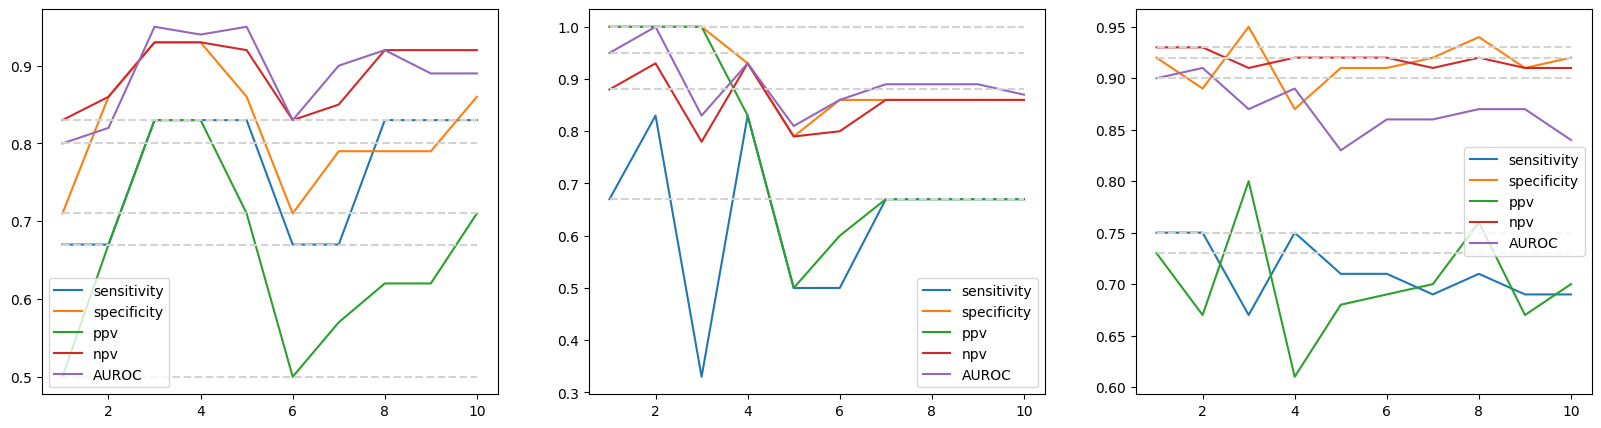

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
client1_v_df.plot(ax=axes[0])
axes[0].hlines(client1_v_df.iloc[:1, :], 1, 10, colors='lightgray', linestyle='--')
client2_v_df.plot(ax=axes[1])
axes[1].hlines(client2_v_df.iloc[:1, :], 1, 10, colors='lightgray', linestyle='--')
test_df.iloc[1:, :].plot(ax=axes[2])
axes[2].hlines(test_df.iloc[1:2, :], 1, 10, colors='lightgray', linestyle='--')
plt.show()

In [75]:
# #FedAvg

# clients_list = [weights1, weights2]

# new_weights = []

# for i in range(len(clients_list[0])):
#     temp = np.zeros_like(clients_list[0][i])
#     for j in range(len(clients_list)):
#         temp += clients_list[j][i]
#     temp = temp/len(clients_list)
#     new_weights.append(temp)
    
    
# # w_avg = np.zeros_like(weights[0])
# # # w_avg = copy.deepcopy(weights[0])
# # for k in range(2):
# #     w_avg += weights[k]
# #     # for i in range(len(weights)):
# #     #     w_avg[k] += weights[i][k]
# #     # w_avg[k] = w_avg[k]/len(weights)
    
# # new_weights = np.stack(weights).mean(0)

# model1 = build_model()
# model1.set_weights(new_weights)
# model2 = build_model()
# model2.set_weights(new_weights)

# model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
#           batch_size=32, verbose=0, callbacks=[early_stop])
# model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
#           batch_size=32, verbose=0, callbacks=[early_stop])

In [76]:
from tensorflow.keras import backend as K

global global_weight, mu
mu = 0.3

def diff_models_norm_2(local_weight, global_weight):
    norm = sum([tf.reduce_sum((local_weight[i] - global_weight[i])**2) for i in range(len(local_weight))])
    return norm

def prox_loss(local_weight):
    def loss(y_true, y_pred):
        global mu
        return K.mean( K.binary_crossentropy(y_true, y_pred) + mu/2 * diff_models_norm_2(local_weight, global_weight), axis=-1)
    
    return loss

def build_prox_model():
    input_layer = Input(shape=(30, 50))
    x = Bidirectional(LSTM(32))(input_layer)
    x = Dropout(0.1)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=prox_loss(local_weight=model.get_weights()), optimizer='adam')

    return model

In [77]:
#FedProx
client_size = []

tf.random.set_seed(0)
np.random.seed(0)

for n in range(1, 21):
    weights_list = []
    if n == 1 :
        #client1
        model1 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client1_t))
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client2_t))
        weights_list.append(model2.get_weights())
        

client_size = []
client1_v_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])
client2_v_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])
test_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])

tf.random.set_seed(0)
np.random.seed(0)

num_round = 10

for n in tqdm(range(1, num_round+1)):
    weights_list = []
    if n == 1 :
        #client1
        model1 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client1_t))
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client2_t))
        weights_list.append(model2.get_weights())
        
        #client local model 각각에 대한 test set 성능 평균
        temp_df = pd.DataFrame(evaluate(model1, X_test, y_test))
        temp_df = pd.concat([temp_df, pd.DataFrame(evaluate(model2, X_test, y_test))], ignore_index=True)
        test_df = test_df.append(temp_df.mean().round(2), ignore_index=True)
            
    else :
        #client1
        model1 = build_prox_model()
        model1.set_weights(new_weights)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_prox_model()
        model2.set_weights(new_weights)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        weights_list.append(model2.get_weights())
    
    client1_v_df = pd.concat([client1_v_df, pd.DataFrame(evaluate(model1, X_client1_v, y_client1_v))], ignore_index=True)
    client2_v_df = pd.concat([client2_v_df, pd.DataFrame(evaluate(model2, X_client1_v, y_client1_v))], ignore_index=True)
    
    #Aggregation
    new_weights = []
    for i in range(len(weights_list[0])): #몇번째 weight
        temp = np.zeros_like(weights_list[0][i])
        for j in range(len(weights_list)): #몇번째 client
            temp += weights_list[j][i]
        temp = temp/len(weights_list)
        new_weights.append(temp)

    global_model = build_model()
    global_model.set_weights(new_weights)
    global_weight = copy.deepcopy(new_weights)
    test_df = pd.concat([test_df, pd.DataFrame(evaluate(global_model, X_test, y_test))], ignore_index=True)

client1_v_df.index = list(range(1, num_round+1))
client2_v_df.index = list(range(1, num_round+1))
test_df.index = ['local model 평균']+list(range(1, num_round+1))

100%|███████████████████████████████████████████| 10/10 [07:44<00:00, 46.48s/it]


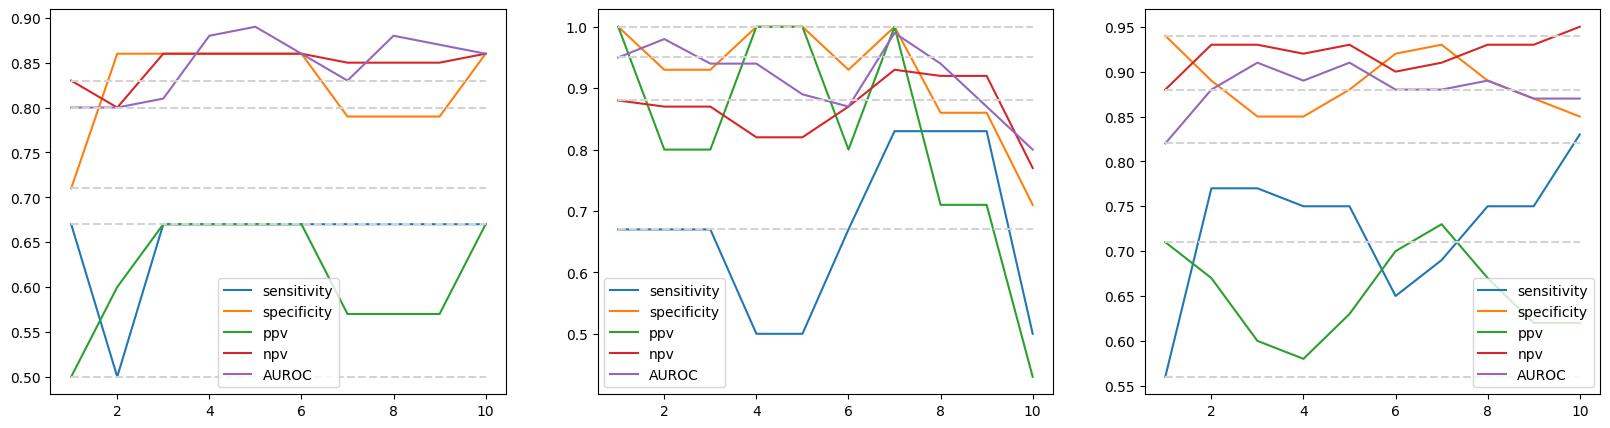

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
client1_v_df.plot(ax=axes[0])
axes[0].hlines(client1_v_df.iloc[:1, :], 1, 10, colors='lightgray', linestyle='--')
client2_v_df.plot(ax=axes[1])
axes[1].hlines(client2_v_df.iloc[:1, :], 1, 10, colors='lightgray', linestyle='--')
test_df.iloc[1:, :].plot(ax=axes[2])
axes[2].hlines(test_df.iloc[1:2, :], 1, 10, colors='lightgray', linestyle='--')
plt.show()

In [79]:
#weighted FedProx
client_size = []

tf.random.set_seed(0)
np.random.seed(0)

for n in range(1, 21):
    weights_list = []
    if n == 1 :
        #client1
        model1 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client1_t))
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client2_t))
        weights_list.append(model2.get_weights())
        

client_size = []
client1_v_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])
client2_v_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])
test_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'ppv', 'npv', 'AUROC'])

tf.random.set_seed(0)
np.random.seed(0)

num_round = 10

for n in tqdm(range(1, num_round+1)):
    weights_list = []
    if n == 1 :
        #client1
        model1 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client1_t))
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        client_size.append(len(X_client2_t))
        weights_list.append(model2.get_weights())
        
        #client local model 각각에 대한 test set 성능 평균
        temp_df = pd.DataFrame(evaluate(model1, X_test, y_test))
        temp_df = pd.concat([temp_df, pd.DataFrame(evaluate(model2, X_test, y_test))], ignore_index=True)
        test_df = test_df.append(temp_df.mean().round(2), ignore_index=True)
            
    else :
        #client1
        model1 = build_prox_model()
        model1.set_weights(new_weights)
        model1.fit(X_client1_t, y_client1_t, epochs=100, validation_data=(X_client1_v, y_client1_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        weights_list.append(model1.get_weights())
        
        #client2
        model2 = build_prox_model()
        model2.set_weights(new_weights)
        model2.fit(X_client2_t, y_client2_t, epochs=100, validation_data=(X_client2_v, y_client2_v),
                  batch_size=8, verbose=0, callbacks=[early_stop])
        weights_list.append(model2.get_weights())
    
    client1_v_df = pd.concat([client1_v_df, pd.DataFrame(evaluate(model1, X_client1_v, y_client1_v))], ignore_index=True)
    client2_v_df = pd.concat([client2_v_df, pd.DataFrame(evaluate(model2, X_client1_v, y_client1_v))], ignore_index=True)
    
    #Aggregation
    new_weights = []
    for i in range(len(weights_list[0])): #몇번째 weight
        temp = np.zeros_like(weights_list[0][i])
        for j in range(len(weights_list)): #몇번째 client
            temp += weights_list[j][i]*(client_size[j]/sum(client_size))
        # temp = temp/len(weights_list)
        new_weights.append(temp)

    global_model = build_model()
    global_model.set_weights(new_weights)
    global_weight = copy.deepcopy(new_weights)
    test_df = pd.concat([test_df, pd.DataFrame(evaluate(global_model, X_test, y_test))], ignore_index=True)

client1_v_df.index = list(range(1, num_round+1))
client2_v_df.index = list(range(1, num_round+1))
test_df.index = ['local model 평균']+list(range(1, num_round+1))


  0%|                                                   | 0/10 [00:31<?, ?it/s]


KeyboardInterrupt: 

In [135]:
# global local_weight, global_weight, mu
# mu = 0.3

# def diff_models_norm_2(local_model, global_model):
#     norm = sum([tf.reduce_sum((local_weight[i] - global_weight[i])**2) for i in range(len(local_weight))])
#     return norm

# def prox_loss(y_true, y_pred):
#     global local_weight, global_weight, mu
#     loss = K.mean( K.binary_crossentropy(y_true, y_pred) + mu/2 * diff_models_norm_2(local_weight, global_weight), axis=-1)
#     return loss

# def build_prox_model():
#     input_layer = Input(shape=(30, 50))
#     x = Bidirectional(LSTM(32))(input_layer)
#     x = Dropout(0.1)(x)
#     output_layer = Dense(1, activation='sigmoid')(x)
    
#     model = Model(inputs=input_layer, outputs=output_layer)
#     model.compile(loss=prox_loss, optimizer='adam')

#     return model